# Answering Business Questions using SQL

In this project we'll explore SQL queries.

Let's pretend we're hired by the "Chinook record" store.

The Chinook database contains information about a fictional digital music shop - kind of like a mini-iTunes store, information about: 
- artists 
- songs and albums from the music shop 
- shop's employees 
- customers 
- customers purchases 

This information is contained in eleven tables which you can see in the schema of Chinook.db:
![Chinook schema](chinook-schema.png)

We'll start from importing all needed libraries and creating some helper functions.

In [1]:
# Import all we need in separate cell:
%matplotlib inline
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

db = "chinook.db"

Let's write several helper functions.

In [2]:
# Return DF from query:
def run_query(q):
    with sqlite3.connect(db) as conn:
        return pd.read_sql(q, conn)

In [3]:
# For execution of the SQL commands:
def run_command(c):
    with sqlite3.connect(db) as conn:
        conn.isolation_level = None
        conn.execute(c)

In [4]:
# See a list of all tables and views in db:
def show_tables():
    q_st = """
    SELECT name, type 
    FROM sqlite_master 
    WHERE type IN ("table","view");
    """
    return run_query(q_st)

In [5]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## Selecting Albums to Purchase

The Chinook record store has just signed a deal with a new record label, and we've been tasked with selecting the first three albums that will be added to the store, from a list of four. All four albums are by artists that don't have any tracks in the store right now - we have the artist names, and the genre of music they produce:

|Artist Name|Genre|
|---|---|
|Regal|Hip-Hop|
|Red Tone|Punk|
|Meteor and the Girls|Pop|
|Slim Jim Bites|Blues|

The record label specializes in artists from the USA, and they have given Chinook some money to advertise the new albums in the USA, so we're interested in finding out which genres sell the best in the USA. So we need to find out which genres sell the most tracks in the USA, and then create a visualization of that data.

In [6]:
# Return each genre, with the number of tracks sold in 
# the USA in: absolute numbers, percentages.

# We need a table-subquery here to aggregate inside it:
q1 = """
WITH usa_sold AS
        (
        SELECT il.* FROM invoice_line il
        INNER JOIN invoice inv ON inv.invoice_id = il.invoice_id
        INNER JOIN customer c ON inv.customer_id = c.customer_id
        WHERE c.country = "USA"
        )
SELECT
    g.name genre,
    COUNT(us.invoice_line_id) tracks_sold,
    CAST(COUNT(us.invoice_line_id) AS FLOAT) / (
        SELECT COUNT(*) FROM usa_sold) percentage_sold
FROM usa_sold us
INNER JOIN track t on t.track_id = us.track_id
INNER JOIN genre g on g.genre_id = t.genre_id
GROUP BY 1
ORDER BY 2 DESC
LIMIT 10;
"""

run_query(q1)

,genre,tracks_sold,percentage_sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Pop,22,0.020932
7,Latin,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


Let's visualize what we've got recently.

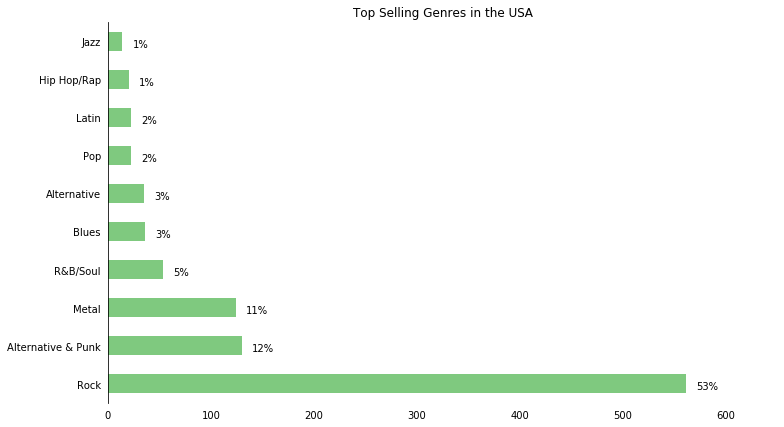

In [7]:
# Get dataframe with helper function,
# with reindexing:
genre_usa_sold = run_query(q1)
genre_usa_sold.set_index("genre", drop=True, inplace=True)

# Matplotlib stuff here:
fig, ax = plt.subplots()
ax1 = genre_usa_sold["tracks_sold"].plot.barh(
    title="Top Selling Genres in the USA",
    xlim=(0, 650),
    colormap=plt.cm.Accent,
    figsize=(12,7)
)

ax1.set_ylabel('')
ax1.tick_params(top=False, bottom=False, left=False, right=False)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

for i, label in enumerate(list(genre_usa_sold.index)):
    score = genre_usa_sold.loc[label, "tracks_sold"]
    label = (genre_usa_sold.loc[label, "percentage_sold"] * 100
            ).astype(int).astype(str) + "%"
    ax1.annotate(str(label), (score + 10, i - 0.15))

plt.show()

Based on the sales, we should purchase the new albums by the following artists:
- Red Tone (Punk)
- Slim Jim Bites (Blues)
- Meteor and the Girls (Pop)

Combined, these three genres only make up only 17% of total sales, so we should be on the lookout for artists and albums from the 'rock' genre, which accounts for 53% of sales.

## Analyzing Employee Sales Performance

Each customer for the Chinook store gets assigned to a sales support agent within the company when they first make a purchase. We have been asked to analyze the purchases of customers belonging to each employee to see if any sales support agent is performing either better or worse than the others.

We might like to consider whether any extra columns from the employee table explain any variance we see, or whether the variance might instead be indicative of employee performance.

In [8]:
# Subquery table to aggregate inside it:
q2 = """
WITH sum_sales AS
        (
        SELECT 
            support_rep_id, 
            SUM(i.total) total
        FROM customer c
        INNER JOIN invoice i ON i.customer_id = c.customer_id
        GROUP BY 1
        )
SELECT
    e.first_name || " " || e.last_name AS support_agent,
    e.hire_date,
    e.country,
    s.total
FROM employee e
INNER JOIN sum_sales s ON s.support_rep_id = e.employee_id
GROUP BY 1
ORDER BY 4 DESC;
"""

run_query(q2)

,support_agent,hire_date,country,total
0,Jane Peacock,2017-04-01 00:00:00,Canada,1731.51
1,Margaret Park,2017-05-03 00:00:00,Canada,1584.00
2,Steve Johnson,2017-10-17 00:00:00,Canada,1393.92


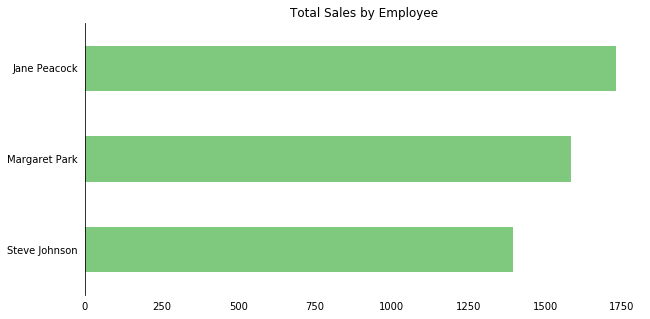

In [9]:
# Get dataframe with helper function,
# with reindexing and sorting:
employee_sales = run_query(q2)
employee_sales.set_index("support_agent", drop=True, inplace=True)
employee_sales.sort_values("total", inplace=True)

# Matplotlib stuff:
ax2 = employee_sales.plot.barh(
    legend=False,
    title='Total Sales by Employee',
    colormap=plt.cm.Accent,
    figsize=(10,5)
)

ax2.set_ylabel('')
ax2.tick_params(top=False, bottom=False, left=False, right=False)

#for spine in ax1.spines:
#    ax1.spines[spine].set_visible(False)

ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

plt.show()

Difference between top-sales employee Jane and Steve from the bottom of our table is approximately 19,4 %, but there's 7 months difference in time they were hired. All three are from Canada, by the way.

## Analyzing Sales by Country

Our next task is to analyze the sales data for customers from each different country. Also we have been given guidance to use the country value from the customers table, and ignore the country from the billing address in the invoice table.
In particular, we have been directed to calculate data, for each country, on the:
- total number of customers
- total value of sales
- average value of sales per customer
- average order value

In [ ]:
# Run this cell once. 
# First let's filter countries with 1 customer:
c1 = """
CREATE VIEW country_filter_one AS
    SELECT 
        CASE WHEN (
                SELECT count(*)
                FROM customer
                where country = c.country
                ) = 1 THEN "Other"
                ELSE c.country
        END AS country,
    c.customer_id,
    il.*
    FROM invoice_line il
    INNER JOIN invoice i ON i.invoice_id = il.invoice_id
    INNER JOIN customer c ON c.customer_id = i.customer_id;
"""
run_command(c1)

In [10]:
# Now we'll select and compute values with previous table
# case "WHEN country = "Other"" is needed to force drop "Other" 
# category to the bottom of table:
q3 = '''
SELECT
    country,
    customers,
    total_sales,
    average_value_sales,
    customer_order_value
FROM
    (
    SELECT
        country,
        count(distinct customer_id) customers,
        SUM(unit_price) total_sales,
        ROUND(SUM(unit_price) / count(distinct invoice_id), 2) average_value_sales,
        ROUND(SUM(unit_price) / count(distinct customer_id), 2) customer_order_value,
            CASE
                WHEN country = "Other" THEN 1
                ELSE 0
            END AS sort
    FROM country_filter_one
    GROUP BY country
    ORDER BY sort ASC, total_sales DESC
    );
'''

run_query(q3)

,country,customers,total_sales,average_value_sales,customer_order_value
0,USA,13,1040.49,7.94,80.04
1,Canada,8,535.59,7.05,66.95
2,Brazil,5,427.68,7.01,85.54
3,France,5,389.07,7.78,77.81
4,Germany,4,334.62,8.16,83.66
5,Czech Republic,2,273.24,9.11,136.62
6,United Kingdom,3,245.52,8.77,81.84
7,Portugal,2,185.13,6.38,92.57
8,India,2,183.15,8.72,91.58
9,Other,15,1094.94,7.45,73.00


## Visualizing Sales by Country

Now that we have our data, we've been asked to create a series of visualizations which communicate our findings, and then make recommendations on which countries may have potential for growth, so the Chinook marketing team can create some new advertising campaigns.

When we're working with data that has many dimensions, it can be tempting to try and communicate every dimension in a single plot. This often results in complex and hard to read visualizations. Instead of this, we should create different plots for each dimension.

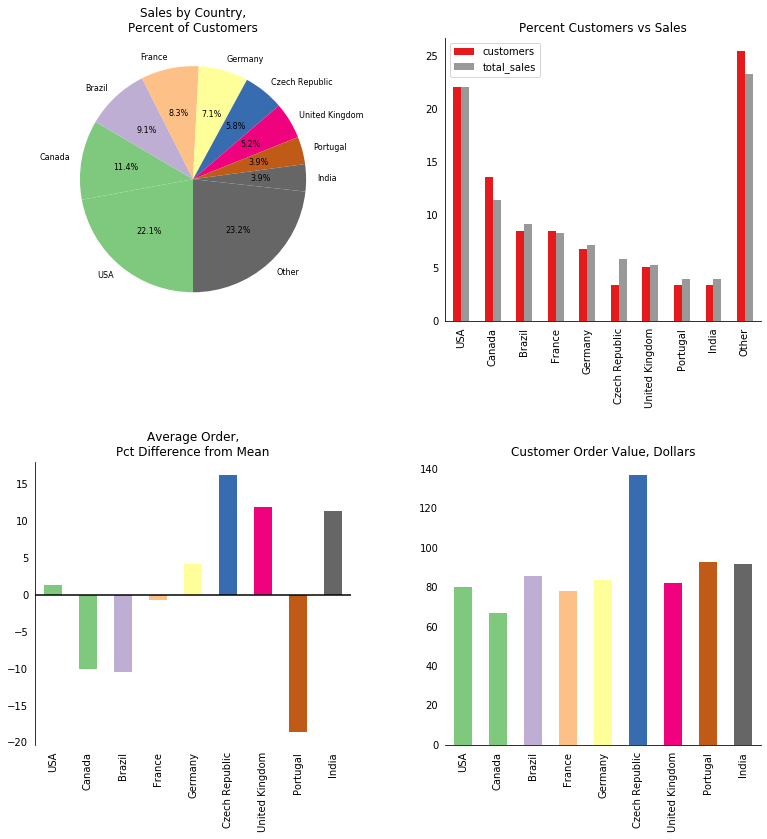

In [11]:
# Get dataframe with helper function,
# with reindexing:
country_sales = run_query(q3)
country_sales.set_index('country', drop=True, inplace=True)


# Matplotlib stuff here:
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, country_sales.shape[0])]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(13, 13))
fig.subplots_adjust(hspace=.5, wspace=.3)
ax1, ax2, ax3, ax4 = axes.flatten()


## upper left
country_sales_total = country_sales['total_sales'].copy().rename('')

country_sales_total.plot.pie(
    ax=ax1,
    startangle=-90,
    counterclock=False,
    title='Sales by Country,\nPercent of Customers',
    colormap=plt.cm.Accent,
    fontsize=8,
    wedgeprops={'linewidth':0},
    autopct='%1.1f%%'
)


## upper right
cols_filter = ['customers', 'total_sales']
customers_money = country_sales[cols_filter].copy()
customers_money.index.name = ''

for c in cols_filter:
    customers_money[c] /= customers_money[c].sum() / 100
    
customers_money.plot.bar(
    ax=ax2,
    colormap=plt.cm.Set1,
    title="Percent Customers vs Sales"
)
ax2.tick_params(top=False, right=False, left=False, bottom=False)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)


## bottom left
avg_order = country_sales["average_value_sales"].copy()
avg_order.index.name = ''
difference_from_avg = avg_order * 100 / avg_order.mean() - 100
difference_from_avg.drop("Other", inplace=True)
difference_from_avg.plot.bar(
    ax=ax3,
    color=colors,
    title="Average Order,\nPct Difference from Mean"
)
ax3.tick_params(top=False, right=False, left=False, bottom=False)
ax3.axhline(0, color='k')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)


## bottom right
ltv = country_sales["customer_order_value"].copy()
ltv.index.name = ''
ltv.drop("Other",inplace=True)
ltv.plot.bar(
    ax=ax4,
    color=colors,
    title="Customer Order Value, Dollars"
)
ax4.tick_params(top=False, right=False, left=False, bottom=False)
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)
ax4.spines["left"].set_visible(False)

plt.show()

Based on the data, there may be opportunity in the following countries:
- Czech Republic
- United Kingdom
- India

It's worth keeping in mind that because the amount of data from each of these countries is relatively low. Because of this, we should be cautious spending too much money on new marketing campaigns, as the sample size is not large enough to give us high confidence. A better approach would be to run small campaigns in these countries, collecting and analyzing the new customers to make sure that these trends hold with new customers.

The "Other" group is not relevant to our analysis, because it accumulates "one customer per country" pair.

## Albums vs Individual Tracks

The Chinook store is setup in a way that allows customer to make purchases in one of the two ways:
- purchase a whole album
- purchase a collection of one or more individual tracks.

The store does not let customers purchase a whole album, and then add individual tracks to that same purchase (unless they do that by choosing each track manually). When customers purchase albums they are charged the same price as if they had purchased each of those tracks separately.

Management are currently considering changing their purchasing strategy to save money. The strategy they are considering is to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album.

We have been asked to find out what percentage of purchases are individual tracks vs whole albums, so that management can use this data to understand the effect this decision might have on overall revenue.

In [12]:
# Starting with subquery table and
# nothing to do here without CASE:
q4 = """
WITH invoice_track AS(
SELECT
    il.invoice_id invoice_id,
    MIN(il.track_id) first_track_id
FROM invoice_line il
GROUP BY 1
)

SELECT
    album_purchase,
    COUNT(invoice_id) AS invoices_number,
    CAST(COUNT(invoice_id) AS float) / (SELECT COUNT(invoice_id) FROM invoice_track) AS percent
FROM (
    SELECT it.*,
        CASE WHEN (
                SELECT t.track_id FROM track t
                WHERE t.album_id = (
                                    SELECT t2.album_id FROM track t2
                                    WHERE t2.track_id = it.first_track_id
                                    ) 
            EXCEPT 
                SELECT il2.track_id FROM invoice_line il2
                WHERE il2.invoice_id = it.invoice_id
                ) IS NULL
        AND 
                (
                SELECT il2.track_id FROM invoice_line il2
                WHERE il2.invoice_id = it.invoice_id
            EXCEPT
                SELECT t.track_id FROM track t
                WHERE t.album_id = (
                                    SELECT t2.album_id FROM track t2
                                    WHERE t2.track_id = it.first_track_id
                                    ) 
                 ) IS NULL
            THEN "Yes"
            ELSE "No"
        END AS "album_purchase"
    FROM invoice_track AS it
)
GROUP BY album_purchase;
"""
run_query(q4)

,album_purchase,invoices_number,percent
0,No,500,0.814332
1,Yes,114,0.185668


Album purchases is 18.6% of purchases. Based on this data, we'll recommend against purchasing only select tracks from albums from record companies, since there is potential to lose one fifth of revenue.

## Artist in Most Playlists

Let's find out which artists are used in the most playlists.

In [13]:
q5 = """
WITH playlists AS(
    SELECT
        ar.name AS artist,
        t.track_id,
        pt.playlist_id
    FROM playlist_track AS pt
    INNER JOIN track AS t ON t.track_id = pt.track_id
    INNER JOIN album AS al ON al.album_id = t.album_id
    INNER JOIN artist AS ar ON ar.artist_id = al.artist_id
)

SELECT
    p.artist,
    COUNT(p.playlist_id) AS playlist_count,
    ROUND(CAST(COUNT(p.playlist_id) AS float) / (SELECT COUNT(*) FROM playlists), 4) * 100 AS percent
FROM playlists AS p
GROUP BY 1
ORDER BY 2 DESC
LIMIT 10;
"""
run_query(q5)

,artist,playlist_count,percent
0,Iron Maiden,516,5.92
1,U2,333,3.82
2,Metallica,296,3.40
3,Led Zeppelin,252,2.89
4,Deep Purple,226,2.59
5,Lost,184,2.11
6,Pearl Jam,177,2.03
7,Faith No More,145,1.66
8,Eric Clapton,145,1.66
9,Lenny Kravitz,143,1.64


Iron Maiden holds approximately 6 % of all playlists places. Top 5 artists together are among 18,62 % of playlists.

## Tracks Purchased vs Not Purchased

Finally, let's check how many tracks were purchased and how many were not.

In [14]:
q6 = """
WITH tracks_s_ns AS(
SELECT
    t.track_id,
    il.invoice_id
FROM track t
LEFT JOIN invoice_line il ON t.track_id = il.track_id
)

SELECT 
    tracks,
    COUNT(track_id) amount
FROM (
    SELECT tsn.*,
        CASE
            WHEN invoice_id IS NOT NULL THEN "Purchased"
            ELSE "Not purchased"
        END AS "tracks"
    FROM tracks_s_ns AS tsn
)
GROUP BY 1
ORDER BY 2 DESC;
"""
run_query(q6)

,tracks,amount
0,Purchased,4757
1,Not purchased,1697


## Conclusion

In this project we put our SQL joining skills to the test, using subqueries, multiple joins, set operations, aggregate functions and more.